# required imports

In [1]:
import torch
import cv2
import copy
import os
import numpy as np

from d2go.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from d2go.utils.demo_predictor import DemoPredictor
from d2go.runner import Detectron2GoRunner
from detectron2.checkpoint import DetectionCheckpointer
from d2go.runner import create_runner

from matplotlib import pyplot as plt

import detectron2.data.transforms as T
from d2go.export.d2_meta_arch import patch_d2_meta_arch
from d2go.export.api import convert_and_export_predictor

patch_d2_meta_arch()


# declare variables

In [2]:
PATH = "/opt/infilect/dev/datasets/balloon_dataset/balloon/val/3800636873_ace2c2795f_b.jpg"
weights_in = '/opt/infilect/dev/repos/experiments/d2go_experiments/balloon_dataset/checkpoints/balloons_6000.pth'
weights_out = "Mask_rcnn/d2goBalloonMrcnnV2.pt"

cfg_name = "mask_rcnn_fbnetv3a_C4.yaml"

# define prediction wrapper model and dataloader

In [3]:
from typing import List, Dict
class Wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        coco_idx_list = [1]

        self.coco_idx = torch.tensor(coco_idx_list)

    def forward(self, inputs: List[torch.Tensor]):
        x = inputs[0].unsqueeze(0) #* 255       
        
#         final FloatBuffer floatBuffer = Tensor.allocateFloatBuffer(3 * resizedBitmap.getWidth() * resizedBitmap.getHeight());
#         TensorImageUtils.bitmapToFloatBuffer(resizedBitmap, 0,0,resizedBitmap.getWidth(),resizedBitmap.getHeight(), PrePostProcessor.NO_MEAN_RGB, PrePostProcessor.NO_STD_RGB, floatBuffer, 0);
#         final Tensor inputTensor =  Tensor.fromBlob(floatBuffer, new long[] {3, resizedBitmap.getHeight(), resizedBitmap.getWidth()});
#         The above line used in android Normalizes, so range between 0 and 1
#         if x.max().item() > 1.0:
#             x = x*255.0
            
        scale = 320.0 / min(x.shape[-2], x.shape[-1])
        # pdb.set_trace()
        x = torch.nn.functional.interpolate(x, scale_factor=scale, mode="bilinear", align_corners=True, recompute_scale_factor=True)
        # pdb.set_trace()
        out = self.model(x[0])
        res : Dict[str, torch.Tensor] = {}
        # print(res)
        res["boxes"] = out[0] / scale
        res["labels"] = torch.index_select(self.coco_idx, 0, out[1])
        res["masks"] = out[2]
        res["scores"] = out[3]
        res["resized_dims"] = out[4]
        # pdb.set_trace()
        return inputs, [res]

def maskrcnn_dataloader(min_size_test=224, max_size_test=320, input_format="RGB"):
    original_image = cv2.imread(PATH)
    _aug = T.ResizeShortestEdge(
                [min_size_test, min_size_test], max_size_test
            )
    for _ in range(3):
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = _aug.get_transform(original_image).apply_image(original_image)
#             image = image/255.0
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            yield [{
                'file_name': '/tmp/detectron2go_tmp_dataset65m2zwxh/images/0.jpg',
                'height': original_image.shape[0],
                'width': original_image.shape[1],
                'image_id': 0,
                'dataset_name': 'default_dataset_test',
                "image":image}]

# load model with custom weights and configurations

In [4]:
def get_model(config_path, weights, num_classes, device=None, runner="d2go.runner.GeneralizedRCNNRunner"):
    cfg = model_zoo.get_config(config_path, trained=False)
    if device is not None:
        cfg.MODEL.DEVICE = device
    elif not torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cpu"
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes

    runner = create_runner(runner)
    model = runner.build_model(cfg)
    checkpoint = torch.load(weights)
    model.load_state_dict(checkpoint.state_dict())
    return model, cfg

# runner = Detectron2GoRunner()
# cfg = model_zoo.get_config("mask_rcnn_fbnetv3a_C4.yaml")
# cfg.DATASETS.TRAIN = ("balloon_train",)
# cfg.DATASETS.TEST = ("balloon_val",)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# # cfg, runner = prepare_for_launch()
# # cfg.RCNN_PREPARE_FOR_QUANT = 'default_rcnn_prepare_for_quant'
# model = runner.build_model(cfg)
# _pretrained = torch.load(weights)
# # print(_state_dict.keys())
# model.load_state_dict(_pretrained.state_dict())

# pytorch_model = model_zoo.get(cfg_name, trained=True)
model, cfg = get_model(
    config_path=cfg_name,
    weights=weights_in,
    num_classes=1,
    device="cpu",
    runner="d2go.runner.GeneralizedRCNNRunner")

Arguments ['width_divisor', 'dw_skip_bnrelu', 'zero_last_bn_gamma'] skipped for op Conv2d


# convert pytorch model to pytorch lite model

In [5]:
print(cfg.RCNN_PREPARE_FOR_QUANT)

# device = torch.device("cpu")
# model.to(device)

data_loader = maskrcnn_dataloader()
predictor_path = convert_and_export_predictor(
    copy.deepcopy(cfg),
    copy.deepcopy(model),
    "torchscript_int8@tracing",
    './',
    data_loader)

orig_model = torch.jit.load(os.path.join(predictor_path, "model.jit"))
wrapped_model = Wrapper(orig_model)
# optionally do a forward

original_image = cv2.imread(PATH)
image_t = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
# image_t = torch.from_numpy(original_image)
wrapped_model([image_t])
scripted_model = torch.jit.script(wrapped_model)
scripted_model.save(weights_out)

default_rcnn_prepare_for_quant


/opt/conda/lib/python3.7/site-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/opt/conda/lib/python3.7/site-packages/detectron2/structures/image_list.py:90: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/opt/conda/lib/python3.7/site-packages/detectron2/structures/boxes.py:158: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every t

# inference from converted d2go model

In [6]:
# ckpt_path = "checkpoints/d2go.pt"
d2go_model = torch.jit.load(weights_out)
_ = d2go_model.eval()

# d2go_predictor = DemoPredictor(d2go_model)

In [7]:
original_image = cv2.imread(PATH)
print(original_image.shape)
image_t = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
image_tensor, res = d2go_model([image_t])
res = res[0]
# outputs = d2go_predictor(im)

(1024, 686, 3)


In [8]:
from PIL import Image, ImageDraw

def mrcnn_annotator(image, bboxes, masks, labels, scores, thresh=0.8, mask_thresh=0.5):
    img = Image.fromarray(image)
    draw = ImageDraw.Draw(img)
    for bbox, mask, label, score in zip(bboxes, masks, labels, scores):
        if score<thresh:
            continue
#         label_str = LABELS[label]
        mask = np.squeeze(mask)
        print(mask.min(), mask.max())
        mask = mask>mask_thresh
        mask = mask.astype('uint8')

        xmin, ymin, xmax, ymax = bbox
        height = int(ymax-ymin)
        width = int(xmax-xmin)
        _m = cv2.resize(mask, (width, height))*255
        pil_mask = Image.fromarray(_m, mode='L')
        
        draw.rectangle(bbox, outline ="red")
        draw.bitmap((xmin, ymin), pil_mask)
#         print(label_str, score, mask.shape, height, width, mask.min(), mask.max())
    return np.array(img)



In [9]:
image = image_tensor[0].numpy()
image = image.transpose([1,2,0]).astype('uint8')

bboxes = res['boxes'].numpy()
masks = res['masks'].numpy()
labels = res['labels'].numpy()
scores = res['scores'].numpy()
resized_dimesnions = res['resized_dims'].numpy()

_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_to_display = mrcnn_annotator(_image, bboxes, masks, labels, scores, 0.8, 0.8)

3.1124966e-12 1.0


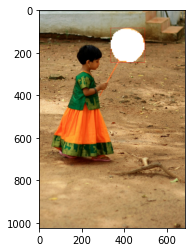

In [10]:
plt.imshow(img_to_display)

In [ ]:
tensor = torch.rand(3, 600, 600)

if tensor.max().item() > 1.0:
    print(tensor*255.0)
    
print(tensor.max().item())